# 🏥 Project: Disease Prediction System — Machine Learning Codebase

### 📖 Introduction: The Goal
Imagine a system where a user enters their symptoms (like "itching" or "high fever") and immediately receives a predicted diagnosis, a description of the disease, and safety precautions.This notebook documents the predictive modelling logic for such a system.  
It covers the entire pipeline:  
- loading raw medical data,  
- cleaning it,  
- preparing it for a web application, and finally,  
- training multiple Machine Learning models to find the most accurate predictor.

### 🏗️ Chapter 1: Setting the Foundation
Before we can build anything, we need to gather our tools. We use Pandas for handling data tables, NumPy for numerical operations, Matplotlib for visualization, and, Scikit-Learn for Predictive Machine Learning modelling operations.

In [1]:
# importing required packages to be used in this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import json
import pickle

%matplotlib inline

### 📂 Chapter 2: Gathering Data

Our data is split across four different CSV files. We need to load them all to get a complete picture.  
1. Symptoms Dataset: The training data containing diseases and their associated symptoms.  
2. Description Dataset: Textual descriptions for every disease.  
3. Precaution Dataset: Recommended steps to take for each disease.  
4. Severity Dataset: A weight (1-7) assigned to symptoms based on how critical they are.


In [2]:
# Loading data from different source files

disease_symptoms_df = pd.read_csv("./Data/disease_symptoms_dataset.csv")
disease_description_df = pd.read_csv("./Data/symptom_description.csv")
disease_precaution_df = pd.read_csv("./Data/symptom_precaution.csv")
symptom_severity_df = pd.read_csv("./Data/symptom_severity.csv")

Now since we have loaded data from different source files and have them in our Pandas Dataframe, let us see how they look like.

In [3]:
display(disease_symptoms_df.head())

display(disease_symptoms_df.info())

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


None

In [4]:
display(disease_description_df.head())

display(disease_description_df.info())

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Disease      41 non-null     object
 1   Description  41 non-null     object
dtypes: object(2)
memory usage: 784.0+ bytes


None

In [5]:
display(disease_precaution_df.head())

display(disease_precaution_df.info())

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Disease       41 non-null     object
 1   Precaution_1  41 non-null     object
 2   Precaution_2  41 non-null     object
 3   Precaution_3  40 non-null     object
 4   Precaution_4  40 non-null     object
dtypes: object(5)
memory usage: 1.7+ KB


None

In [6]:
display(symptom_severity_df.head())

display(symptom_severity_df.info())

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Symptom  133 non-null    object
 1   weight   133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


None

### 🧹 Chapter 3: Cleaning & Understanding the Data
Real-world data is rarely perfect. Our first step is to inspect the disease, symptoms and their associated data from the dataset.  
One of the main problem that we generatlly encounter in scenarios similar to ours is the **Duplicate Data Problem**. We suspect the dataset might contain repeated rows. Redundant data can cause our model to overfit (memorize) specific examples rather than learning general patterns. We verify this by counting duplicates.

In [7]:
# Standardize all column names to be in lower-case

disease_symptoms_df.columns = disease_symptoms_df.columns.str.lower()
disease_description_df.columns = disease_description_df.columns.str.lower()
disease_precaution_df.columns = disease_precaution_df.columns.str.lower()
symptom_severity_df.columns = symptom_severity_df.columns.str.lower()

In [8]:
# Standardize all disease and symptom names to be in lower-case

disease_symptoms_df['disease'] = disease_symptoms_df['disease'].str.lower().str.strip()
disease_description_df['disease'] = disease_description_df['disease'].str.lower().str.strip()
disease_precaution_df['disease'] = disease_precaution_df['disease'].str.lower().str.strip()
symptom_severity_df['symptom'] = symptom_severity_df['symptom'].str.lower().str.strip()

In [9]:
total_disease_symptom_data = len(disease_symptoms_df)
count_of_duplicate_disease_symptom_data = disease_symptoms_df.duplicated().sum()
count_of_unique_disease_symptom_data = total_disease_symptom_data - count_of_duplicate_disease_symptom_data

print(f"TOTAL RECORDS = {total_disease_symptom_data}")
print(f"DUPLICATE RECORDS = {count_of_duplicate_disease_symptom_data}, UNIQUE RECORDS = {count_of_unique_disease_symptom_data}")

TOTAL RECORDS = 4920
DUPLICATE RECORDS = 4616, UNIQUE RECORDS = 304


OBSERVATION: A massive portion of the data (4616 out of 4920 records) consists of duplicates. We must remove them to ensure the model learns efficiently.

In [10]:
disease_symptoms_df = disease_symptoms_df.drop_duplicates().reset_index(drop=True)
disease_symptoms_df.head()

,disease,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,symptom_6,symptom_7,symptom_8,symptom_9,symptom_10,symptom_11,symptom_12,symptom_13,symptom_14,symptom_15,symptom_16,symptom_17
0,fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
total_disease_description_data = len(disease_description_df)
count_of_duplicate_disease_description_data = disease_description_df.duplicated().sum()
count_of_unique_disease_description_data = total_disease_description_data - count_of_duplicate_disease_description_data

print(f"TOTAL RECORDS = {total_disease_description_data}")
print(f"DUPLICATE RECORDS = {count_of_duplicate_disease_description_data}, UNIQUE RECORDS = {count_of_unique_disease_description_data}")

TOTAL RECORDS = 41
DUPLICATE RECORDS = 0, UNIQUE RECORDS = 41


So now since we have got rid of the duplicates from our central data set, we will implement the similar approach for the associated dataset as well.

In [12]:
total_disease_precaution_data = len(disease_precaution_df)
count_of_duplicate_disease_precaution_data = disease_precaution_df.duplicated().sum()
count_of_unique_disease_precaution_data = total_disease_precaution_data - count_of_duplicate_disease_precaution_data

print(f"TOTAL RECORDS = {total_disease_precaution_data}")
print(f"DUPLICATE RECORDS = {count_of_duplicate_disease_precaution_data}, UNIQUE RECORDS = {count_of_unique_disease_precaution_data}")

TOTAL RECORDS = 41
DUPLICATE RECORDS = 0, UNIQUE RECORDS = 41


In [13]:
total_symptom_severity_data = len(symptom_severity_df)
count_of_duplicate_symptom_severity_data = symptom_severity_df.duplicated().sum()
count_of_unique_symptom_severity_data = total_symptom_severity_data - count_of_duplicate_symptom_severity_data

print(f"TOTAL RECORDS = {total_symptom_severity_data}")
print(f"DUPLICATE RECORDS = {count_of_duplicate_symptom_severity_data}, UNIQUE RECORDS = {count_of_unique_symptom_severity_data}")

TOTAL RECORDS = 133
DUPLICATE RECORDS = 0, UNIQUE RECORDS = 133


**DUPLICATE COUNT OF DISEASE AND SYMPTOMS -**  
- Count of Diseases : 41  
- Count of Symptoms : 133  
- Count of Diseases with Description : 41  
- Count of Diseases with Precaution  : 41  
- Count of Symptoms with Severity    : 133  
  
OBSERVATION: 
- All diseases have a description and precaution associated with it.
- All Symptoms have a severity associated with it.

In [14]:
disease_symptoms_df['disease'].value_counts().sort_values(ascending=True)

fungal infection                            5
heart attack                                5
allergy                                     5
paralysis (brain hemorrhage)                5
urinary tract infection                     5
aids                                        5
acne                                        5
gastroenteritis                             5
drug reaction                               6
hypertension                                6
dimorphic hemmorhoids(piles)                6
impetigo                                    6
arthritis                                   6
cervical spondylosis                        6
bronchial asthma                            7
gerd                                        7
psoriasis                                   7
peptic ulcer diseae                         7
hepatitis c                                 7
(vertigo) paroymsal  positional vertigo     7
osteoarthristis                             7
alcoholic hepatitis               

### 🔗 Chapter 4: Connecting the Dots
We have separate files for Descriptions and Precautions. To build a helpful application, we need to link these together so that when a disease is predicted, we can look up its details immediately.  
At this point, we have verified the quality of the auxiliary datasets to ensure they don't contain duplicates or missing values. Alongside establishing connections among all the datasets, we will also build labels for our data (since we deal with categorical values here)

Creating a Master Table - Before moving ahead, let's format the disease description & precaution properly in a single master DataFrame. This acts as our "Knowledge Base."

In [15]:
print(f"Count of Unique Diseases in Description source = {disease_description_df['disease'].nunique()}") 
print(f"Count of Unique Diseases in Precaution source  = {disease_precaution_df['disease'].nunique()}") 

Count of Unique Diseases in Description source = 41
Count of Unique Diseases in Precaution source  = 41


In [16]:
print(f"""
Are the sets of Disease Names the same? = { 
    set(disease_description_df['disease']) == set(disease_precaution_df['disease']) }

Diseases in description but NOT in precaution = {
    set(disease_description_df['disease']) - set(disease_precaution_df['disease']) }

Diseases in precaution but NOT in description = { 
    set(disease_precaution_df['disease']) - set(disease_description_df['disease']) }
""")


Are the sets of Disease Names the same? = False

Diseases in description but NOT in precaution = {'dimorphic hemorrhoids(piles)'}

Diseases in precaution but NOT in description = {'dimorphic hemmorhoids(piles)'}



In [17]:
# Spelling mismatch: "hemmorhoids" - Correct, "hemorrhoids" - Wrong

disease_precaution_df["disease"] = ( disease_precaution_df["disease"].str.replace("hemmorhoids", "hemorrhoids", regex=False) )

print(f"""
Are the sets of Disease Names the same after correction? = { 
    set(disease_description_df['disease']) == set(disease_precaution_df['disease']) }
""")


Are the sets of Disease Names the same after correction? = True



In [18]:
disease_description_precaution_df = pd.merge(disease_description_df, disease_precaution_df, how='inner', on='disease')

display(disease_description_precaution_df.head())

print(f"Total Records  = {len(disease_description_precaution_df)}")
print(f"Total Diseases = {disease_description_precaution_df['disease'].nunique()}")

,disease,description,precaution_1,precaution_2,precaution_3,precaution_4
0,drug reaction,An adverse drug reaction (ADR) is an injury ca...,stop irritation,consult nearest hospital,stop taking drug,follow up
1,malaria,An infectious disease caused by protozoan para...,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,allergy,An allergy is an immune system response to a f...,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,hypothyroidism,"Hypothyroidism, also called underactive thyroi...",reduce stress,exercise,eat healthy,get proper sleep
4,psoriasis,Psoriasis is a common skin disorder that forms...,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


Total Records  = 41
Total Diseases = 41


In [19]:
# Check for any missing information (NaN values) after the merge
disease_description_precaution_df[
    disease_description_precaution_df['disease'].isna() |
    disease_description_precaution_df['description'].isna() |
    disease_description_precaution_df['precaution_1'].isna() |
    disease_description_precaution_df['precaution_2'].isna() |
    disease_description_precaution_df['precaution_3'].isna() |
    disease_description_precaution_df['precaution_4'].isna()
]

,disease,description,precaution_1,precaution_2,precaution_3,precaution_4
2,allergy,An allergy is an immune system response to a f...,apply calamine,cover area with bandage,NaN,use ice to compress itching
36,heart attack,The death of heart muscle due to the loss of b...,call ambulance,chew or swallow asprin,keep calm,NaN


2 missing values found - one in column `precaution_3` and another in column `precaution_4`. This is acceptable and won't be a problematic scenario in future, but for serialization purposes, we would want to replace NaN with empty string.

In [20]:
disease_description_precaution_df = disease_description_precaution_df.fillna("")

disease_description_precaution_df[
    disease_description_precaution_df['disease'].isna() |
    disease_description_precaution_df['description'].isna() |
    disease_description_precaution_df['precaution_1'].isna() |
    disease_description_precaution_df['precaution_2'].isna() |
    disease_description_precaution_df['precaution_3'].isna() |
    disease_description_precaution_df['precaution_4'].isna()
]

,disease,description,precaution_1,precaution_2,precaution_3,precaution_4


### 📦 Chapter 5: Preparing for the Web App (Serialization)
Our Machine Learning model will live inside a Flask web (backend) application. The frontend needs easy access to disease details and symptom lists without querying a database every time.  
To solve this, we convert our master DataFrames into JSON dictionaries. This creates a lightweight data structure that the web app can easily read to display drop-down menus or result cards.

1. Create a dictionary for Diseases (Description + Precautions)

In [21]:
disease_json = []

for index in range(len(disease_description_precaution_df)):
    disease_json.append({
        'id': index,
        'name': disease_description_precaution_df.iloc[index]['disease'].title(),
        'description': disease_description_precaution_df.iloc[index]['description'],
        'precaution1': disease_description_precaution_df.iloc[index]['precaution_1'],
        'precaution2': disease_description_precaution_df.iloc[index]['precaution_2'],
        'precaution3': disease_description_precaution_df.iloc[index]['precaution_3'],
        'precaution4': disease_description_precaution_df.iloc[index]['precaution_4']
    })

2. Create a dictionary for Symptoms (formatting names for better readability) along with its severity

In [22]:
symptom_json = []

for index in range(len(symptom_severity_df)):
    symptom_json.append({
        'id': index,
        'code': symptom_severity_df.iloc[index]['symptom'],
        'name': ' '.join(symptom_severity_df.iloc[index]['symptom'].split('_')).title(),
        'severity': {
            'weight': str(symptom_severity_df.iloc[index]['weight'])
        }
    })

Save the two file dictionaries in JSON files - these will be used by the web app

In [23]:
with open('./Data/Disease_Info.json', 'w') as f:
    json.dump(disease_json, f, indent=4) 

with open('./Data/Symptoms_Info.json', 'w') as f:
    json.dump(symptom_json, f, indent=4)

### 📦 Chapter 6: Preparing Data for Model Training

In [24]:
symptom_numbered_cols = [col for col in disease_symptoms_df.columns if col.lower().startswith("symptom_")]

all_symptom_cols = pd.unique(symptom_severity_df['symptom'])
all_symptom_cols = [symptom for symptom in all_symptom_cols if pd.notna(symptom)]

In [25]:
one_hot_symptom_df = pd.DataFrame(0, index=disease_symptoms_df.index, columns=all_symptom_cols)

display(one_hot_symptom_df.head())

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Build a list of updates instead of writing cell-by-cell (avoids fragmentation)
updates = []

for existing_col in symptom_numbered_cols:
    for index, symptom in disease_symptoms_df[existing_col].items():
        if pd.notna(symptom):
            symptom = str(symptom).strip().lower()
            if symptom in one_hot_symptom_df.columns:
                updates.append((index, symptom))

# Apply all updates at once (fast, no fragmentation)
for index, symptom in updates:
    one_hot_symptom_df.at[index, symptom] = 1

one_hot_symptom_df = one_hot_symptom_df.fillna(0).astype(int)

one_hot_symptom_df.head()


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df = pd.concat([one_hot_symptom_df, disease_symptoms_df['disease']], axis=1)
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,disease
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fungal infection


### 🤖 Chapter 7: Training Ground

The following sections test which algorithm acts as the best "Brain" for our doctor.  

At this stage, the notebook assumes the raw text data has been converted into numerical vectors for Training and Testing sets. We split our data into features (`X` - symptoms) and targets (`Y` - prognosis).  

**Step 1: Train Test Split (Ratio = 80:20)**

In [28]:
X = df.loc[:, df.columns != 'disease'] 
y = df['disease'] 

# Stratified Train/Test Split (80/20) 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
) 

**NOTE: Why No Encoding or Scaling Is Required?**

A. **Feature Matrix (X)**  
All features in `X` are binary indicators:
- `0` → symptom absent  
- `1` → symptom present  

Since the data is already numeric and standardized to a fixed range (0–1), no additional preprocessing is needed:  
- No encoding is required because there are no categorical text values.
- No scaling is required because binary values are already normalized and unaffected by standardization or normalization techniques.
- Models like `Naive Bayes`, `Logistic Regression`, `Decision Trees`, and `Random Forests` work naturally with binary inputs.
  
B. **Target Variable (y)**  
The target variable `y` contains disease names as strings. Scikit‑learn classifiers automatically handle string labels by internally converting them to numeric classes during training.  
Therefore:  
- No label encoding is required for `y`.
- Predictions will naturally return the original disease names.

The dataset is already in a model‑ready format:
- X → numeric, binary, clean  
- y → string labels handled automatically  

This allows us to train models directly without extra preprocessing steps.


We will use 5-fold Stratified Cross - Validation

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Contender 1: Naive Bayes**  
This is a probabilistic classifier. It's fast and often works surprisingly well for text/category classification.

In [30]:
# Initialize model
gnb_model = GaussianNB()

In [31]:
# cv_scores_gnb = cross_val_score(gnb_model, X, y, cv=5, scoring='accuracy') 
# print(f"Cross‑validated GNB accuracy: {cv_scores_gnb.mean() * 100:.2f} %") 

cv_scores_gnb = cross_val_score( gnb_model, X_train, y_train, cv=skf, scoring='accuracy' ) 
print(f"Stratified K-Fold CV Accuracy for GNB: {cv_scores_gnb.mean() * 100:.2f} %")

/home/debmalya/Desktop/GitHub/Disease-Prediction-System-using-Machine-Learning/Backend/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Stratified K-Fold CV Accuracy for GNB: 98.77 %


In [32]:
# Train final model on training set 
gnb_model.fit(X_train, y_train)

GaussianNB()

In [33]:
# Evaluate on test set
y_pred_gnb = gnb_model.predict(X_test) 

In [34]:
# Accuracy Score
accuracy_score_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"GNB Test Accuracy: {accuracy_score_gnb * 100:.2f} %")

GNB Test Accuracy: 98.36 %


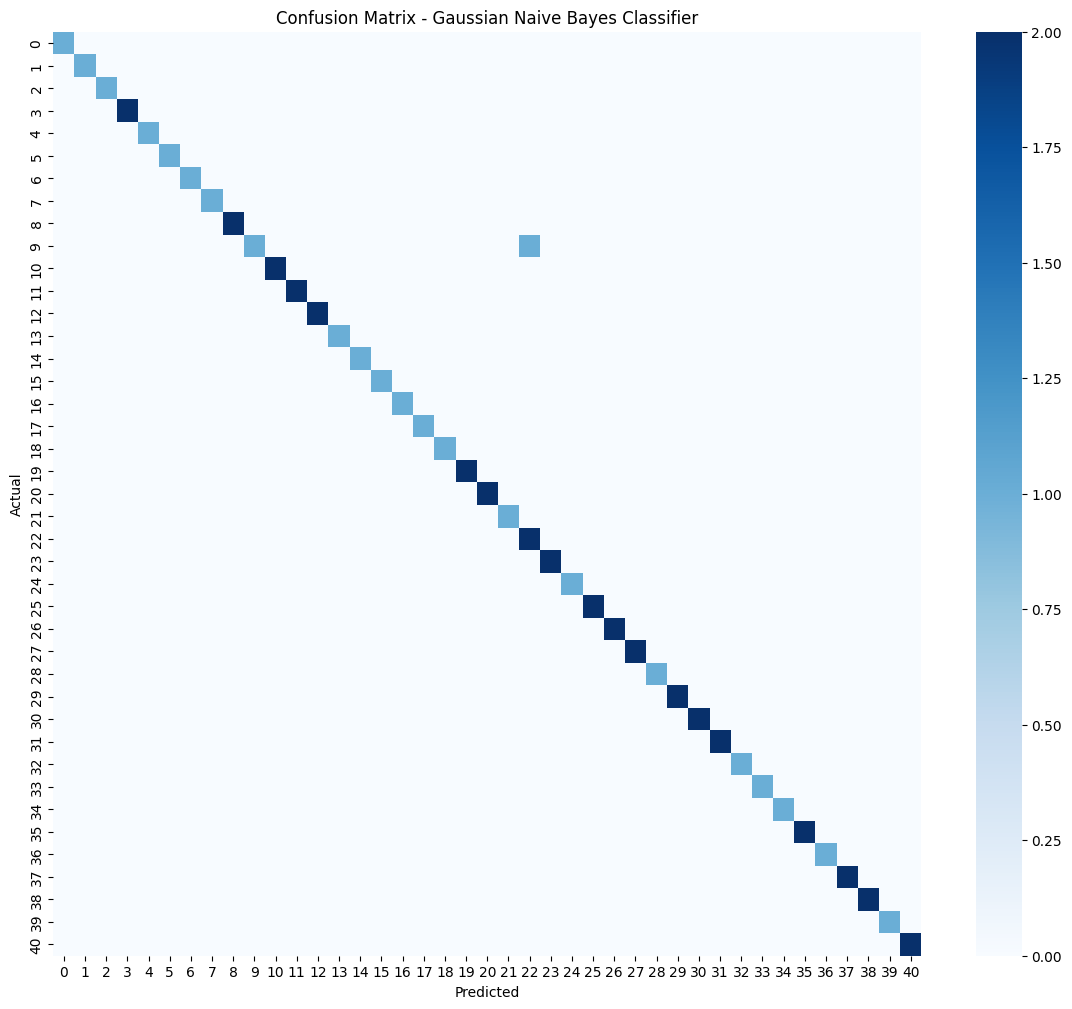

In [35]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb) 

plt.figure(figsize=(14, 12))
sns.heatmap(cm_gnb, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Gaussian Naive Bayes Classifier") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()

**Contender 2: Decision Tree**  
This model creates a flowchart-like structure (e.g., "If fever AND rash exists -> Dengue"). It mimics human diagnostic logic.

In [36]:
# Initialize model 
dt_model = DecisionTreeClassifier(random_state=42)

In [37]:
cv_scores_dt = cross_val_score( dt_model, X_train, y_train, cv=skf, scoring='accuracy' )
print(f"Stratified K-Fold CV Accuracy for Decision Tree Classifier: {cv_scores_dt.mean() * 100:.2f} %") 

Stratified K-Fold CV Accuracy for Decision Tree Classifier: 69.95 %


/home/debmalya/Desktop/GitHub/Disease-Prediction-System-using-Machine-Learning/Backend/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [38]:
# Train final model on full training set 
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [39]:
# Predict on test set 
y_pred_dt = dt_model.predict(X_test)

In [40]:
# Accuracy Score for Decision Tree model
accuracy_score_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier Test Accuracy: {accuracy_score_dt * 100:.2f} %") 

Decision Tree Classifier Test Accuracy: 65.57 %


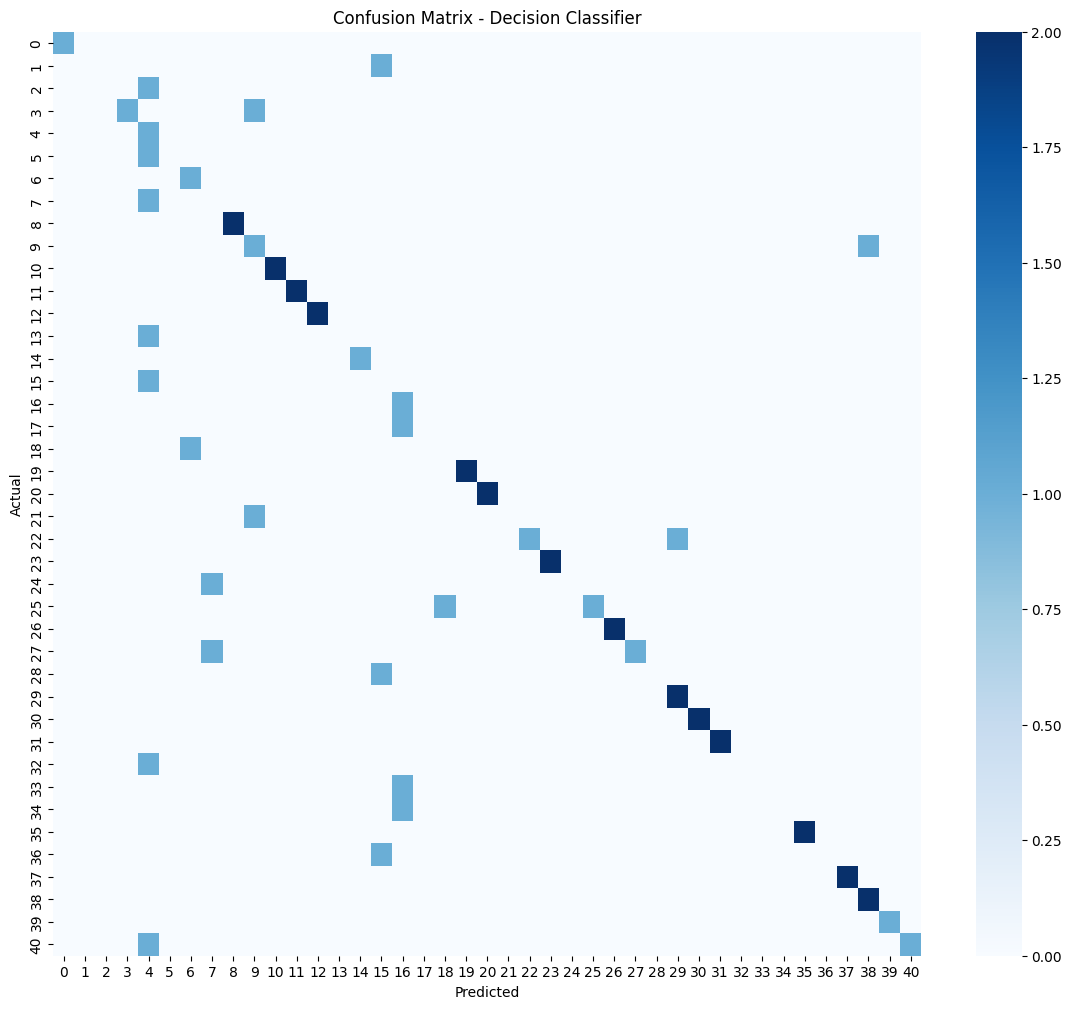

In [41]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(14, 12)) 
sns.heatmap(cm_dt, annot=False, cmap="Blues") 
plt.title("Confusion Matrix - Decision Classifier") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()

**Contender 3: Random Forest**  
If one Decision Tree is good, a forest of them is better. This model averages the results of multiple trees to reduce errors and improve stability (specially required since results from Decision Tree classifier wasn't great).

In [42]:
# Initialize model 
rf_model = RandomForestClassifier( 
    n_estimators=300, 
    random_state=42, 
    n_jobs=-1 
)

In [43]:
cv_scores_rf = cross_val_score( 
    rf_model, 
    X_train, 
    y_train, 
    cv=skf, 
    scoring='accuracy' 
)
print(f"Stratified K-Fold CV Accuracy for Random Forest Classifier: {cv_scores_rf.mean() * 100:.2f} %") 

/home/debmalya/Desktop/GitHub/Disease-Prediction-System-using-Machine-Learning/Backend/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Stratified K-Fold CV Accuracy for Random Forest Classifier: 98.77 %


In [44]:
# Train final model on full training set 
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [45]:
# Predict on test set 
y_pred_rf = rf_model.predict(X_test)

In [46]:
#  Accuracy Score for Decision Tree model
accuracy_score_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classfier Test Accuracy: {accuracy_score_rf * 100:.2f} %") 

Random Forest Classfier Test Accuracy: 100.00 %


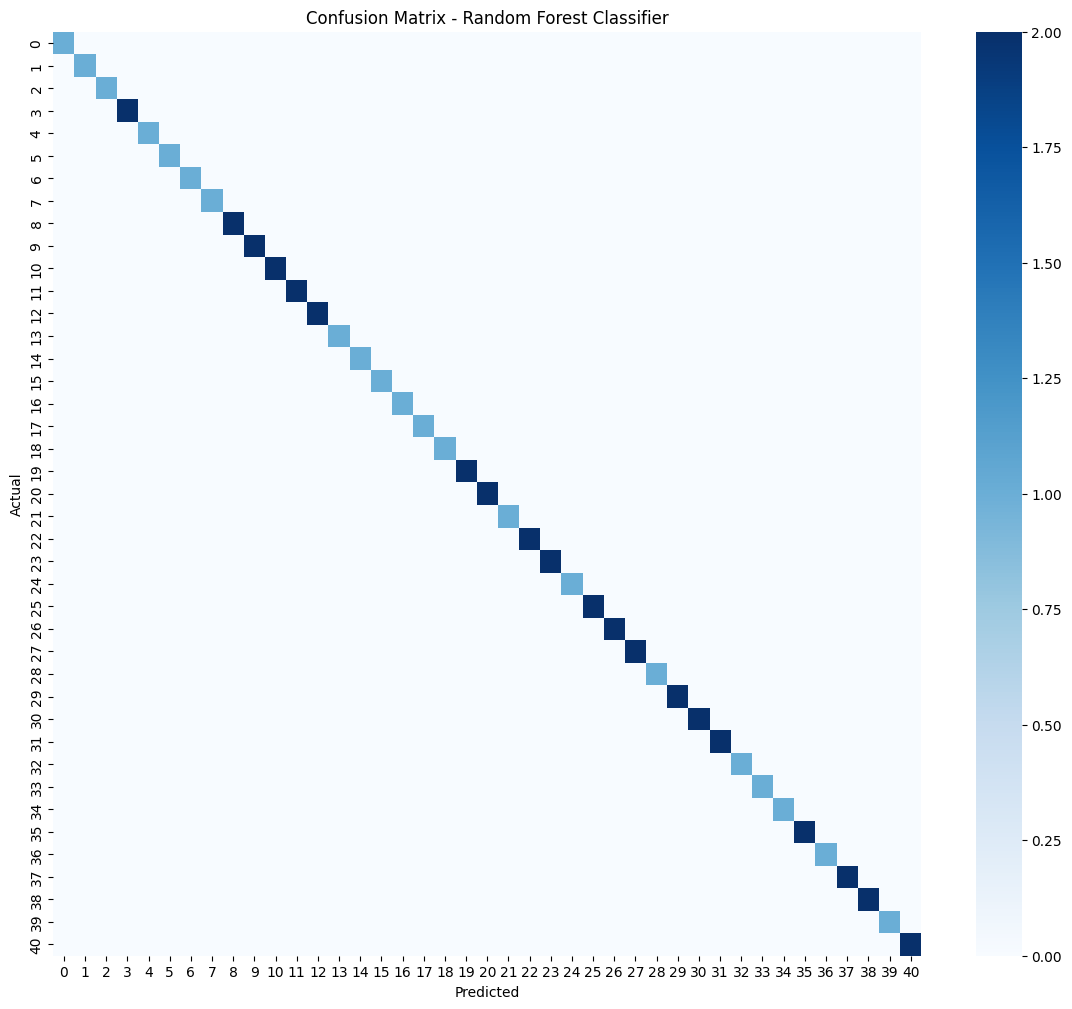

In [47]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(14, 12)) 
sns.heatmap(cm_rf, annot=False, cmap="Blues") 
plt.title("Confusion Matrix - Random Forest Classifier") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()

**Contender 4: Support Vector Machine (SVM)**  
SVM tries to draw a clear line (or hyperplane) that separates different disease categories in a high-dimensional space.

In [48]:
# Initialize model 
svm_clf_model = svm.SVC(kernel='linear')

In [49]:
cv_scores_svm = cross_val_score( 
    svm_clf_model, 
    X_train, 
    y_train, 
    cv=skf, 
    scoring='accuracy' 
) 

print(f"Stratified K-Fold CV Accuracy for SVM Classifier: {cv_scores_svm.mean() * 100:.2f} %")

Stratified K-Fold CV Accuracy for SVM Classifier: 98.77 %


/home/debmalya/Desktop/GitHub/Disease-Prediction-System-using-Machine-Learning/Backend/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [50]:
# Train final model on full training set 
svm_clf_model.fit(X_train, y_train)

SVC(kernel='linear')

In [51]:
# Predict on test set 
y_pred_svm = svm_clf_model.predict(X_test)

In [52]:
#  Accuracy Score for SVM Classifier model
accuracy_score_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classfier Test Accuracy: {accuracy_score_svm * 100:.2f} %") 

SVM Classfier Test Accuracy: 100.00 %


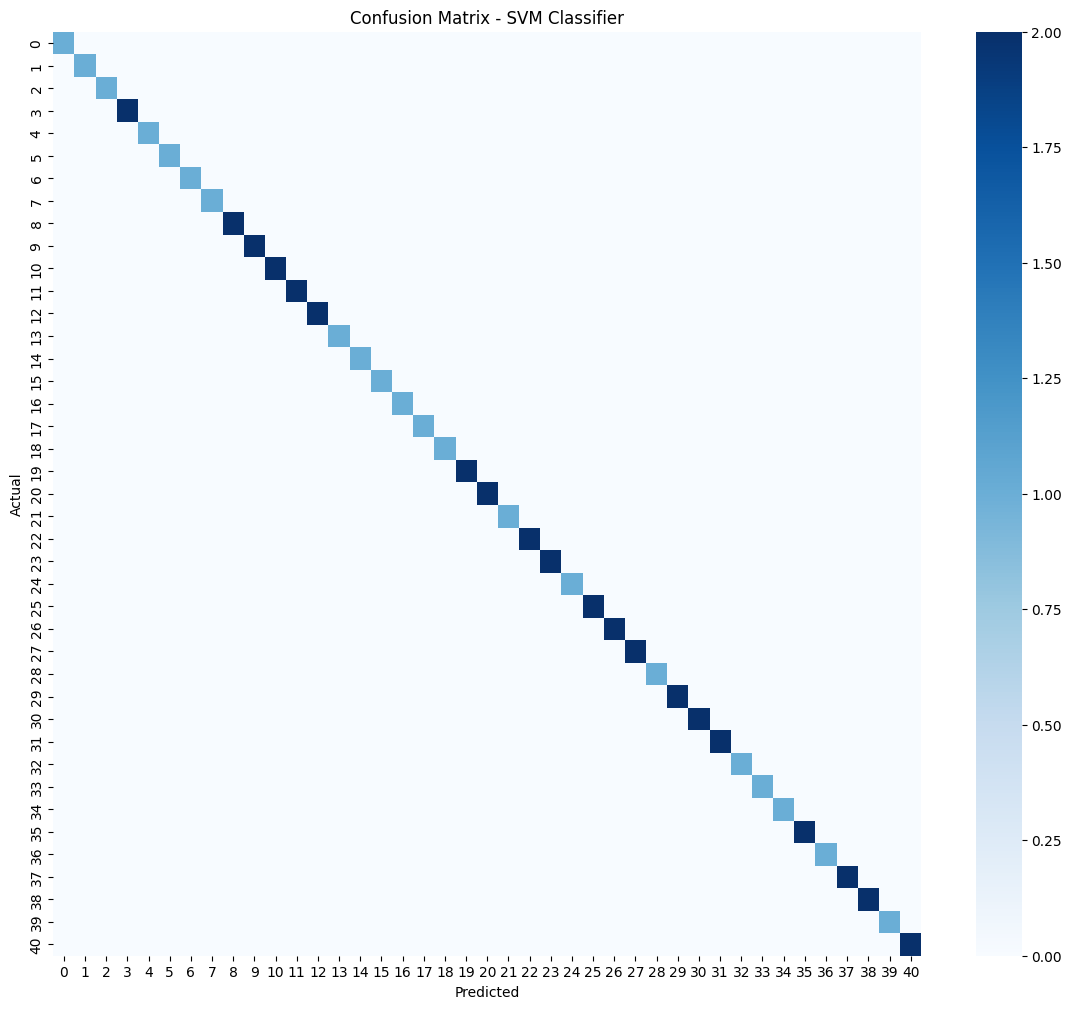

In [53]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(14, 12)) 
sns.heatmap(cm_svm, annot=False, cmap="Blues") 
plt.title("Confusion Matrix - SVM Classifier") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()


**🏁 Conclusion**  
By training these four models, we can compare their accuracy scores based on the cross-fold validation and predictions on test data. We found `Naive Bayes Classifier`, `Random Forest Classifier` and `SVM Classifier` to be best performing, while `Decision Trees` approach performed very poorly in comparison to the former 3 modelling techniques.   
In the following section, we understand the differences in the individual model's performance by graphically plotting the metrics.

/tmp/ipykernel_315820/3064510655.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


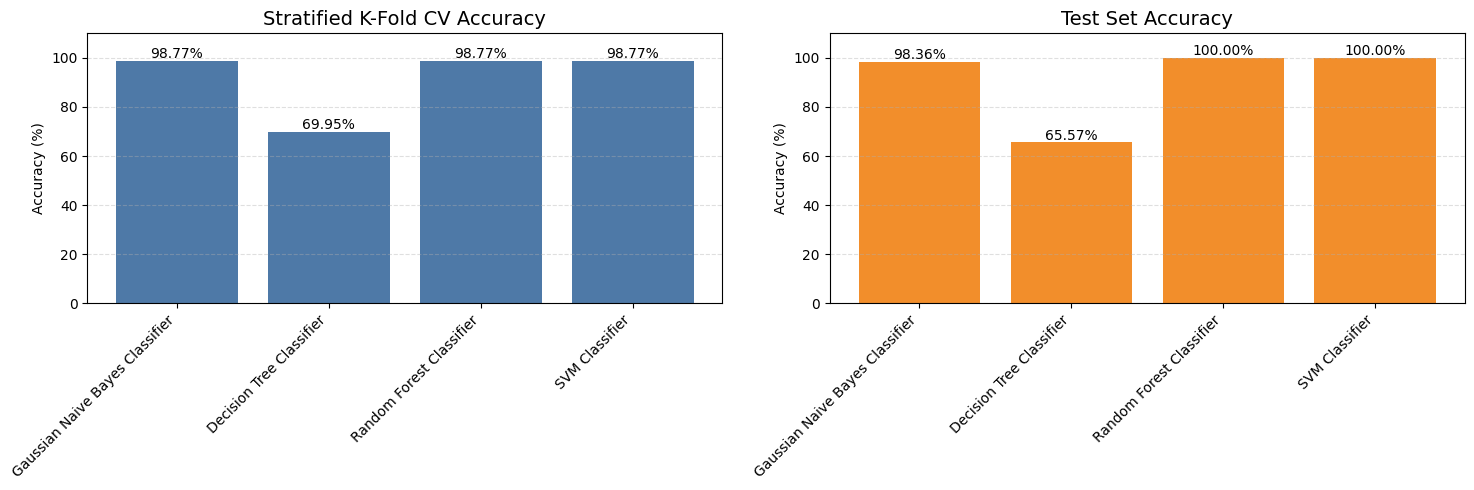

In [54]:
cv_accuracy_score = {
    'Gaussian Naive Bayes Classifier': cv_scores_gnb,
    'Decision Tree Classifier': cv_scores_dt,
    'Random Forest Classifier': cv_scores_rf,
    'SVM Classifier': cv_scores_svm
}

test_set_accuracy_score = {
    'Gaussian Naive Bayes Classifier': accuracy_score_gnb,
    'Decision Tree Classifier': accuracy_score_dt,
    'Random Forest Classifier': accuracy_score_rf,
    'SVM Classifier': accuracy_score_svm
}


# Extract model names 
models = list(cv_accuracy_score.keys()) 
# Compute mean CV accuracy for each model 
cv_means = [scores.mean() * 100 for scores in cv_accuracy_score.values()] 
# Test set accuracy values 
test_scores = [score * 100 for score in test_set_accuracy_score.values()] 


# Create side-by-side subplots 
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

# --- Left Plot: CV Accuracy --- 
axes[0].bar(models, cv_means, color="#4e79a7") 
axes[0].set_title("Stratified K-Fold CV Accuracy", fontsize=14) 
axes[0].set_ylabel("Accuracy (%)") 
axes[0].set_ylim(0, 110) 
axes[0].grid(axis='y', linestyle='--', alpha=0.4) 
# Add labels on bars 
for i, v in enumerate(cv_means): 
    axes[0].text(i, v + 1, f"{v:.2f}%", ha='center') 

# --- Right Plot: Test Set Accuracy --- 
axes[1].bar(models, test_scores, color="#f28e2b") 
axes[1].set_title("Test Set Accuracy", fontsize=14) 
axes[1].set_ylabel("Accuracy (%)") 
axes[1].set_ylim(0, 110) 
axes[1].grid(axis='y', linestyle='--', alpha=0.4) 
# Add labels on bars 
for i, v in enumerate(test_scores): 
    axes[1].text(i, v + 1, f"{v:.2f}%", ha='center') 

# Rotate x-labels for readability 
for ax in axes: 
    ax.set_xticklabels(models, rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

/home/debmalya/Desktop/GitHub/Disease-Prediction-System-using-Machine-Learning/Backend/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_315820/2160969128.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


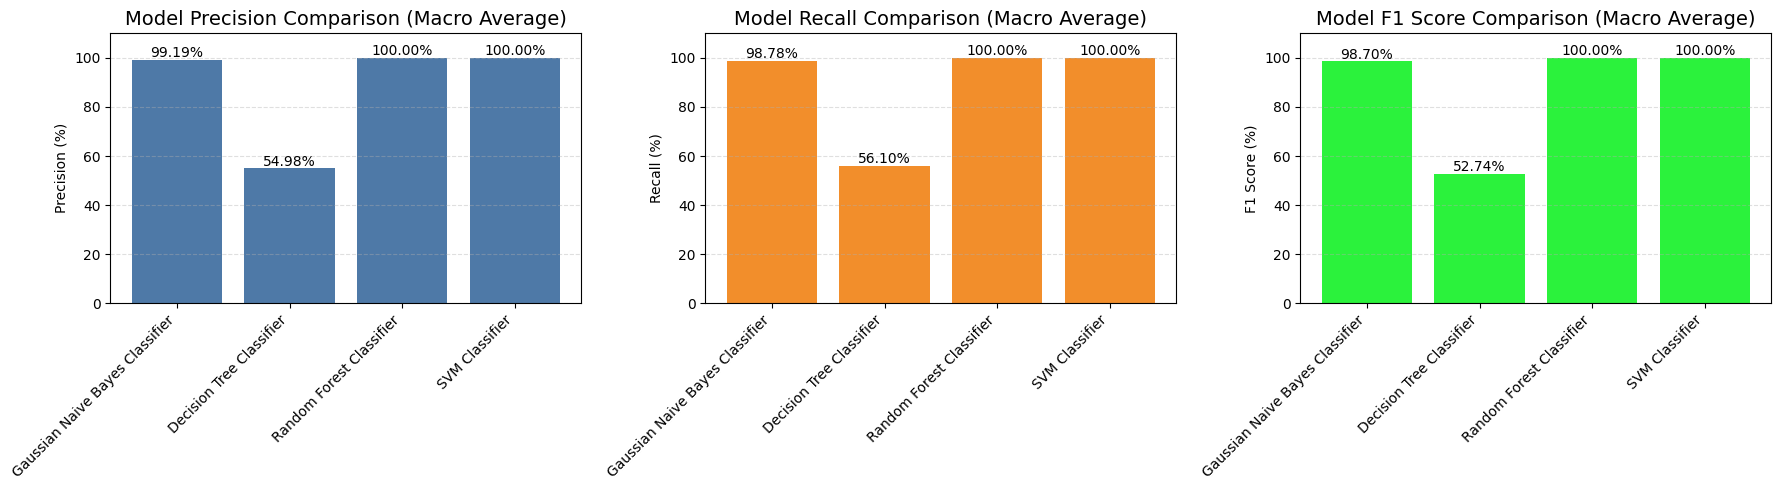

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_scores_dict = {
    'Gaussian Naive Bayes Classifier': precision_score(y_test, y_pred_gnb, average='macro'),
    'Decision Tree Classifier': precision_score(y_test, y_pred_dt, average='macro'),
    'Random Forest Classifier': precision_score(y_test, y_pred_rf, average='macro'),
    'SVM Classifier': precision_score(y_test, y_pred_svm, average='macro'),
}

recall_scores_dict = {
    'Gaussian Naive Bayes Classifier': recall_score(y_test, y_pred_gnb, average='macro'),
    'Decision Tree Classifier': recall_score(y_test, y_pred_dt, average='macro'),
    'Random Forest Classifier': recall_score(y_test, y_pred_rf, average='macro'),
    'SVM Classifier': recall_score(y_test, y_pred_svm, average='macro'),
}

f1_scores_dict = {
    'Gaussian Naive Bayes Classifier': f1_score(y_test, y_pred_gnb, average='macro'),
    'Decision Tree Classifier': f1_score(y_test, y_pred_dt, average='macro'),
    'Random Forest Classifier': f1_score(y_test, y_pred_rf, average='macro'),
    'SVM Classifier': f1_score(y_test, y_pred_svm, average='macro'),
}

models = list(precision_scores_dict.keys())
precision_scores = [v * 100 for v in precision_scores_dict.values()]
recall_scores = [v * 100 for v in recall_scores_dict.values()]
f1_scores = [v * 100 for v in f1_scores_dict.values()]

# Create side-by-side subplots 
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# --- Left Plot: Precision --- 
axes[0].bar(models, precision_scores, color="#4e79a7") 
axes[0].set_title("Model Precision Comparison (Macro Average)", fontsize=14) 
axes[0].set_ylabel("Precision (%)") 
axes[0].set_ylim(0, 110) 
axes[0].grid(axis='y', linestyle='--', alpha=0.4) 
# Add labels on bars 
for i, v in enumerate(precision_scores): 
    axes[0].text(i, v + 1, f"{v:.2f}%", ha='center') 

# --- Middle Plot: Recall --- 
axes[1].bar(models, recall_scores, color="#f28e2b") 
axes[1].set_title("Model Recall Comparison (Macro Average)", fontsize=14) 
axes[1].set_ylabel("Recall (%)") 
axes[1].set_ylim(0, 110) 
axes[1].grid(axis='y', linestyle='--', alpha=0.4) 
# Add labels on bars 
for i, v in enumerate(recall_scores): 
    axes[1].text(i, v + 1, f"{v:.2f}%", ha='center') 

# --- Right Plot: F1 Score --- 
axes[2].bar(models, f1_scores, color="#2bf23c") 
axes[2].set_title("Model F1 Score Comparison (Macro Average)", fontsize=14) 
axes[2].set_ylabel("F1 Score (%)") 
axes[2].set_ylim(0, 110) 
axes[2].grid(axis='y', linestyle='--', alpha=0.4) 
# Add labels on bars 
for i, v in enumerate(f1_scores): 
    axes[2].text(i, v + 1, f"{v:.2f}%", ha='center') 

# Rotate x-labels for readability 
for ax in axes: 
    ax.set_xticklabels(models, rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

###